In [1]:
#from transformers import AutoTokenizer, AutoModel
import sklearn
import pandas as pd
import json
import numpy as np
import ast
from tqdm.auto import tqdm
import statistics
import math

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load existing data

In [2]:
import csv
embedding_path = '../data/specter/df_embeddings.csv'
submission_path = '../data/database/outputs/df_prestige.csv'


df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]
#df_embeddings.to_csv('df_embeddings.csv', index = False)

tqdm.pandas()
def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.progress_apply(lambda x: get_numpy(x), axis =1)

100%|██████████████████████████| 2819/2819 [00:04<00:00, 696.22it/s]


In [3]:
df_embeddings.head()

Unnamed: 0,paper_id,embedding
S1VaB4cex,S1VaB4cex,"[0.08104710280895233, 0.5308438539505005, 0.08..."
H1W1UN9gg,H1W1UN9gg,"[0.07500883936882019, 0.5360254049301147, 0.04..."
r1GKzP5xx,r1GKzP5xx,"[0.11110689491033554, 1.2004060745239258, -0.0..."
S1J0E-71l,S1J0E-71l,"[-0.14411762356758118, 0.7905676364898682, 0.4..."
SJGCiw5gl,SJGCiw5gl,"[-0.26906102895736694, -0.11083536595106125, -..."


In [4]:
df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]
df_submission_labels.head()

,id,title,conf_year,keywords,AVG_rating
0,B1-Hhnslg,Prototypical Networks for Few-shot Learning,2017,"[""Deep learning"", ""Transfer Learning""]",5.000000
1,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,2017,"[""Natural language processing"", ""Deep learning""]",6.333333
2,B12Js_yRb,Learning to Count Objects in Natural Images fo...,2018,"[""visual question answering"", ""vqa"", ""counting""]",5.333333
3,B13EC5u6W,Thinking like a machine — generating visual ra...,2018,"[""interpretability"", ""generative adversarial n...",6.333333
4,B13njo1R-,Progressive Reinforcement Learning with Distil...,2018,"[""Reinforcement Learning"", ""Distillation"", ""Tr...",6.333333


In [5]:
#break the embeddings into years

df_submission_labels[df_submission_labels['conf_year']==2017]

df_embeddings_2017 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2017], left_on='paper_id',right_on='id')
df_embeddings_2018 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2018], left_on='paper_id',right_on='id')
df_embeddings_2019 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2019], left_on='paper_id',right_on='id')

# Agglomerative Clustering of Anchor Group

In [6]:
#cluster only on the 2017  with cosine distance of 0.1

from sklearn.cluster import AgglomerativeClustering
x = np.array(df_embeddings_2017.embedding.tolist())
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage="average", metric = 'cosine').fit(x)

df_embeddings_2017['agg_cluster'] = clustering.labels_.tolist()
df_embeddings_2017.head()

,paper_id,embedding,id,title,conf_year,keywords,AVG_rating,agg_cluster
0,S1VaB4cex,"[0.08104710280895233, 0.5308438539505005, 0.08...",S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,2017,[],5.666667,31
1,H1W1UN9gg,"[0.07500883936882019, 0.5360254049301147, 0.04...",H1W1UN9gg,Deep Information Propagation,2017,"[""Theory"", ""Deep learning""]",8.333333,249
2,r1GKzP5xx,"[0.11110689491033554, 1.2004060745239258, -0.0...",r1GKzP5xx,Recurrent Normalization Propagation,2017,"[""Deep learning"", ""Optimization""]",5.333333,20
3,S1J0E-71l,"[-0.14411762356758118, 0.7905676364898682, 0.4...",S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,2017,"[""Unsupervised Learning"", ""Applications"", ""Dee...",3.333333,393
4,SJGCiw5gl,"[-0.26906102895736694, -0.11083536595106125, -...",SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,2017,"[""Deep learning"", ""Transfer Learning""]",7.333333,407


In [7]:
#testing uncomment if necessary
#clustering.labels_
#unique_elements, counts_elements = np.unique(clustering.labels_, return_counts=True)
#print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))

In [8]:
#anchor group computing cluster centroid
from sklearn.neighbors import NearestCentroid
x = np.array(df_embeddings_2017.embedding.tolist())
y = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(x, y)
#clf.predict()
#print(clf.classes_)
#print(type((clf.centroids_)[1]))
#clf.predict(df_embeddings_2017[df_embeddings_2017['agg_cluster']==425].embedding.tolist())
#df_embeddings_2017[df_embeddings_2017['agg_cluster']==425] = clf.predict(x).tolist()
#df_embeddings_2017

NearestCentroid()

# Variable Ratio Matching with Agg Cluster and mimizing cosine distance

In [9]:
df_embeddings_2018.shape

(911, 7)

In [40]:
#https://stackoverflow.com/questions/62352209/how-to-get-11-corresponding-matches-using-sklearn-knearest-neighbors
#https://towardsdatascience.com/apply-propensity-score-method-in-causal-inference-part-2-k-nearest-neighbor-matching-c0cd2cdb0f74

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid

#setting up KNN for 2018
#note radius parameter doesnt do anything unless we use radius_neighbors
neigh = NearestNeighbors( n_neighbors=100, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)



#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
tuning_param_cos_dist = 0.30
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    #rng = neigh.radius_neighbors([clf.centroids_[cluster_id]])
    #break
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

In [41]:
#testing 
#dict_agg_cluster_matches[0][0].keywords

In [42]:
tqdm.pandas()

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.progress_apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')



100%|██████████████████████████| 489/489 [00:00<00:00, 16065.47it/s]


In [43]:
#testing
#df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].head()
#df_embeddings_2017[['keywords_2018']]

In [44]:
#examples
first_row = df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].iloc[0]

print(first_row.title,'|', first_row.keywords)
print('\n')

for title, keywords_2018, cos_dist_2018 in zip(first_row.titles_2018,first_row.keywords_2018, first_row.cos_dist_2018):
    print(title)
    print(cos_dist_2018)
    print(keywords_2018)
#print(df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','keywords_2018']].iloc[0].titles_2018)

FractalNet: Ultra-Deep Neural Networks without Residuals | []


Building effective deep neural networks one feature at a time
0.10664268866456994
["convolution neural networks", "architecture search", "meta-learning", "representational capacity"]
Tandem Blocks in Deep Convolutional Neural Networks
0.11264963543577333
["resnet", "residual", "shortcut", "convolutional", "linear", "skip", "highway"]
Simple and efficient architecture search for Convolutional Neural Networks
0.11758314559444139
["Deep Learning", "Hyperparameter Optimization", "Architecture Search", "Convolutional Neural Networks", "Network Morphism", "Network Transformation", "SGDR", "Cosine annealing", "hill climbing"]
Learning Parsimonious Deep Feed-forward Networks
0.1181014457317826
["Parsimonious Deep Feed-forward Networks", "structure learning", "classification", "overfitting", "fewer parameters", "high interpretability"]
Beyond Finite Layer Neural Networks: Bridging Deep Architectures and Numerical Differential Equat

In [45]:
df_cos_dist_sample = pd.concat([df_embeddings_2017[['agg_cluster']],pd.DataFrame(df_embeddings_2017["cos_dist_2018"].to_list())], axis=1)

In [46]:
#df_cos_dist_sample

In [47]:
#df_cos_dist_sample.describe()

# Parameter Tuning

In [48]:
from scipy.special import gamma, factorial
#https://github.com/mick001/Control-Charts-Shiny
#https://www.uaar.edu.pk/fs/books/12.pdf check chapter 4.2 for reference
def get_c_4(n):
    #returns c4 constant    
    return math.sqrt(2/(n-1))*gamma(n/2)/gamma((n-1)/2)

def get_b4(n):
    #returns b4 constant
    return 1 + 3 * math.sqrt( 1 - get_c_4(n)**2 ) / get_c_4(n)

def get_a3(n):
    #returns a3 constant
    return 3 / (get_c_4(n) * math.sqrt(n)) 

def get_x_double_bar(df_spc):
    #returns x double bar with variable sample size
    x_double_bar = (df_spc.mean(axis=1) * df_spc.count(axis=1)).sum() / (df_spc.count(axis=1).sum())
    return x_double_bar

def get_s_bar(df_spc):
    #return s bar
    top = ((df_spc.count(axis =1) - 1) * df_spc.std(axis=1)**2 ).sum()
    bottom = df_spc.count(axis=1).sum() - df_spc.shape[0]

    return (top/bottom)**(0.5)
    
    
def spc_xbar(df_spc):
    #takes in a dataframe from tuning script and outputs number of samples out of control
    xdouble_bar = get_x_double_bar(df_spc)
    UCL_x_bar = xdouble_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
    out_control_count = UCL_x_bar < df_spc.mean(axis = 1)
    return out_control_count.sum()

def spc_sbar(df_spc):
    #takes in a dataframe from tuning script and outputs number of samples out of control
    return (df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc) < df_spc.std(axis = 1)).sum()

In [49]:
#tuning charts
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,10000):
    input_row = {}
    match_number = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    #if match_number == df_tuning.shape[0]:
    df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
    df_spc['count'] = df_spc.count(axis=1)
    df_spc = df_spc[df_spc['count']>=2]
    df_spc = df_spc.drop(columns= ['count'])    
    if df_spc.shape[0] >=300:
        try:
            out_control_count_xbar = spc_xbar(df_spc)
            out_control_count_sbar = spc_sbar(df_spc)
            input_row['cosine_distance'] = tuning_param_cos_dist
            input_row['out_control_points_xbar'] = out_control_count_xbar
            input_row['out_control_points_sbar'] = out_control_count_sbar
            input_row['sample_size'] = df_spc.shape[0]
            data.append(input_row)

        except:
            continue
x = pd.DataFrame(data)     

<AxesSubplot: xlabel='cosine_distance', ylabel='out_control_points_sbar'>

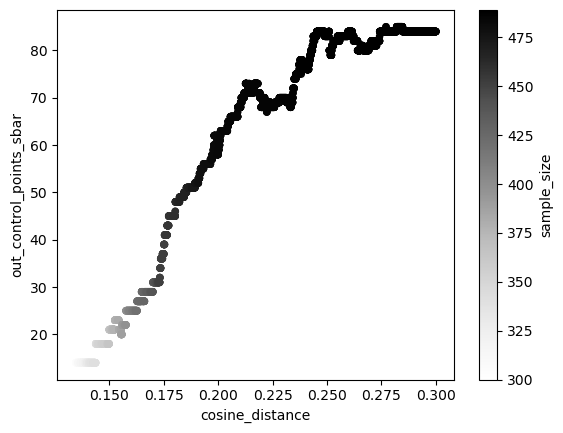

In [50]:
x.plot.scatter(x = 'cosine_distance', y='out_control_points_sbar', c='sample_size')

<AxesSubplot: xlabel='cosine_distance', ylabel='out_control_points_xbar'>

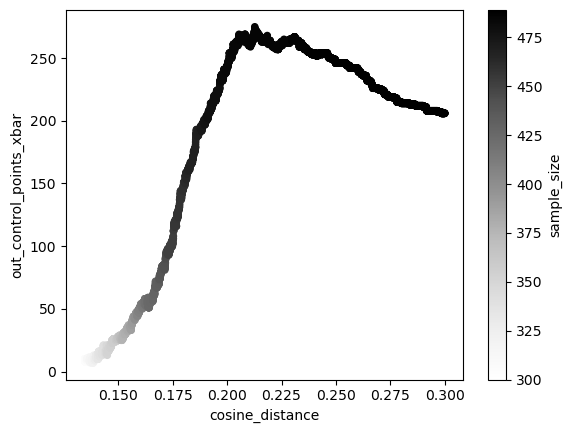

In [51]:
x.plot.scatter(x = 'cosine_distance', y='out_control_points_xbar', c ='sample_size')

<AxesSubplot: title={'center': 'Before X bar Chart'}>

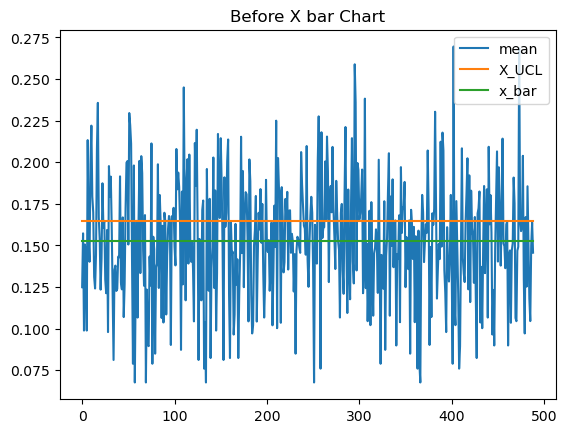

In [32]:
#http://www.bessegato.com.br/UFJF/resources/table_of_control_chart_constants_old.pdf
#given the reference table there
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"

tuning_param_cos_dist = 0.3
df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc['count'] = df_spc.count(axis=1)
df_spc = df_spc[df_spc['count']>=2]
df_spc = df_spc.drop(columns= ['count'])   
x_double_bar = get_x_double_bar(df_spc)
s_bar = get_s_bar(df_spc)

df_spc['X_UCL'] = x_double_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
df_spc['S_UCL'] = df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc)
df_spc['mean'] =df_tuning[df_tuning<=tuning_param_cos_dist].mean(axis=1)
df_spc['std'] = df_tuning[df_tuning<=tuning_param_cos_dist].std(axis=1)

df_spc['x_bar'] = pd.Series([x_double_bar for x in range(len(df_spc.index))])
df_spc['s_bar'] = pd.Series([s_bar for x in range(len(df_spc.index))])


df_spc[['mean','X_UCL','x_bar']].plot(title='Before X bar Chart')



<AxesSubplot: >

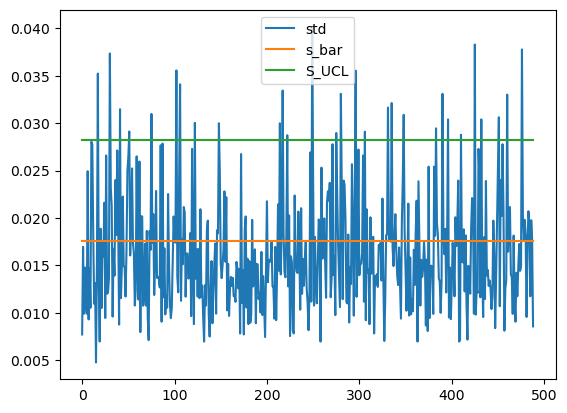

In [23]:
df_spc[['std','s_bar','S_UCL']].plot(title='Before S bar Chart')

<AxesSubplot: title={'center': 'After X bar chart'}>

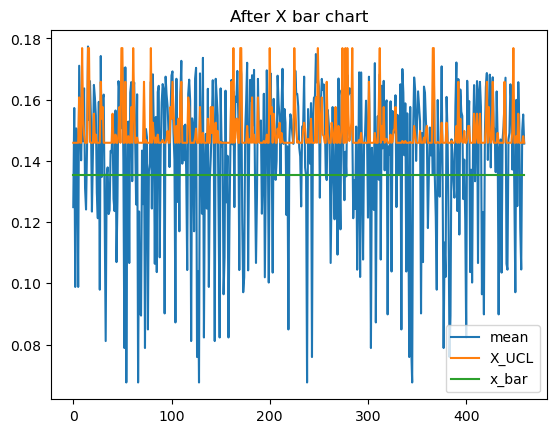

In [35]:
#http://www.bessegato.com.br/UFJF/resources/table_of_control_chart_constants_old.pdf
#given the reference table there
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"

tuning_param_cos_dist = 0.18
df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc['count'] = df_spc.count(axis=1)
df_spc = df_spc[df_spc['count']>=2]
df_spc = df_spc.drop(columns= ['count'])    
x_double_bar = get_x_double_bar(df_spc)
s_bar = get_s_bar(df_spc)

df_spc1 = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc1['count'] = df_spc1.count(axis=1)
df_spc1 = df_spc1[df_spc1['count']>=2]
df_spc1 = df_spc1.drop(columns= ['count'])   

df_spc['X_UCL'] = x_double_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
df_spc['S_UCL'] = df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc)
df_spc['mean'] =df_spc1.mean(axis=1)
df_spc['std'] = df_spc1.std(axis=1)



df_spc=df_spc.reset_index()
df_spc['x_bar'] = pd.Series([x_double_bar for x in range(len(df_spc.index))])
df_spc['s_bar'] = pd.Series([s_bar for x in range(len(df_spc.index))])


df_spc[['mean','X_UCL','x_bar']].plot(title= "After X bar chart")

<AxesSubplot: title={'center': 'After X bar chart'}>

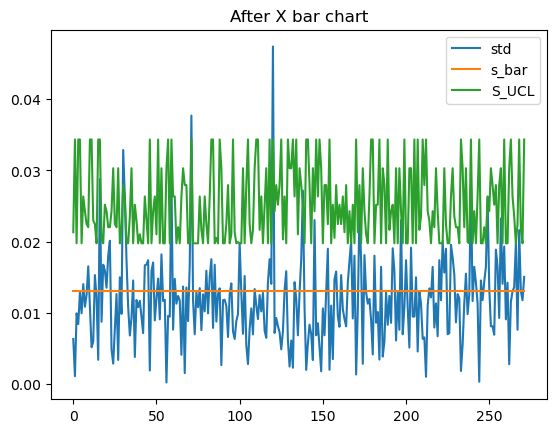

In [34]:
df_spc[['std','s_bar','S_UCL']].plot(title= "After X bar chart")

# Potential Outcome Model

In [52]:
#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
tuning_param_cos_dist = 0.18
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    #rng = neigh.radius_neighbors([clf.centroids_[cluster_id]])
    #break
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

tqdm.pandas()

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.progress_apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')



100%|██████████████████████████| 489/489 [00:00<00:00, 17719.20it/s]


In [53]:
#Matching potential outcome estimator
#Keith et al. 2020
#https://aclanthology.org/2020.acl-main.474.pdf
#equation 7 and 8

def lambda_get_match_potential_outcomes(row):
    #equation 7 in the paper
    paper_ids = row.id_2018
    big_m = len(row.id_2018)
    if big_m == 0:
        return None
    ratings = [df_embeddings_2018[df_embeddings_2018['paper_id'] == paper_id].AVG_rating.values[0] for paper_id in paper_ids]
    return sum(ratings)/big_m
        
    

df_embeddings_2017['match_ave_rating'] = df_embeddings_2017.progress_apply(lambda row: lambda_get_match_potential_outcomes(row), axis =1)

#equation 8 in the paper
SATE = (df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']).sum()/df_embeddings_2017.shape[0]
#check that the 2 vectors are same size.
STD = ((df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating'])/df_embeddings_2017.shape[0]).std()
print('SATE:', SATE)
print('STD: ', STD)

#question we matched with replacement. So what do we do now?

100%|████████████████████████████| 489/489 [00:03<00:00, 149.33it/s]

SATE: -0.1708778898736505
STD:  0.0026873382908168424


In [54]:
import itertools

df_embeddings_2017.id_2018.to_list()

pd.DataFrame(list(itertools.chain.from_iterable(df_embeddings_2017.id_2018.to_list())),columns=['paper_id']).value_counts()

paper_id 
rkLyJl-0-    140
SJ3dBGZ0Z    133
HyKZyYlRZ    131
SkHkeixAW    121
rkTBjG-AZ    108
            ... 
Hkbd5xZRb      1
rJLTTe-0W      1
Sk03Yi10Z      1
HktK4BeCZ      1
ry9tUX_6-      1
Length: 844, dtype: int64

# SDM calculation

In [29]:
df_embeddings_2017

,paper_id,embedding,id,title,conf_year,keywords,AVG_rating,agg_cluster,titles_2018,keywords_2018,id_2018,cos_dist_2018,match_ave_rating
0,S1VaB4cex,"[0.08104710280895233, 0.5308438539505005, 0.08...",S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,2017,[],5.666667,31,[Building effective deep neural networks one f...,"[[""convolution neural networks"", ""architecture...","[SkffVjUaW, rkmoiMbCb, SySaJ0xCZ, HJMN-xWC-, r...","[0.10664268866456994, 0.11264963543577333, 0.1...",5.795833
1,H1W1UN9gg,"[0.07500883936882019, 0.5360254049301147, 0.04...",H1W1UN9gg,Deep Information Propagation,2017,"[""Theory"", ""Deep learning""]",8.333333,249,[Gaussian Process Behaviour in Wide Deep Neura...,"[[""Gaussian Processes"", ""Bayesian Deep Learnin...","[H1-nGgWC-, rJGY8GbR-, SJTB5GZCb, B1EA-M-0Z, H...","[0.1282783432911625, 0.1298041758883901, 0.133...",5.883333
2,r1GKzP5xx,"[0.11110689491033554, 1.2004060745239258, -0.0...",r1GKzP5xx,Recurrent Normalization Propagation,2017,"[""Deep learning"", ""Optimization""]",5.333333,20,"[Training RNNs as Fast as CNNs, Revisiting Bay...","[[""recurrent neural networks"", ""natural langua...","[rJBiunlAW, Hkp3uhxCW, BkoXnkWAb, HkMCybx0-, r...","[0.07733028243319018, 0.07777403673736871, 0.0...",5.083333
3,S1J0E-71l,"[-0.14411762356758118, 0.7905676364898682, 0.4...",S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,2017,"[""Unsupervised Learning"", ""Applications"", ""Dee...",3.333333,393,[Efficiently applying attention to sequential ...,"[[""RNNs""], [""sequence modelling"", ""language"", ...","[BJ78bJZCZ, rkdU7tCaZ, Hyp3i2xRb, rJQDjk-0b, H...","[0.11792664464071645, 0.12981918176542884, 0.1...",5.616667
4,SJGCiw5gl,"[-0.26906102895736694, -0.11083536595106125, -...",SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,2017,"[""Deep learning"", ""Transfer Learning""]",7.333333,407,[Efficient Sparse-Winograd Convolutional Neura...,"[[""deep learning"", ""convolutional neural netwo...","[HJzgZ3JCW, BJjBnN9a-, B1EA-M-0Z, SJtChcgAW, S...","[0.11150463220611118, 0.1296516213485921, 0.13...",5.425000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,BJ9fZNqle,"[-1.0406643152236938, 1.8355070352554321, 0.42...",BJ9fZNqle,Multi-modal Variational Encoder-Decoders,2017,"[""Deep learning"", ""Structured prediction"", ""Na...",3.666667,17,[WHAI: Weibull Hybrid Autoencoding Inference f...,"[[], [], [""Variational Inference"", ""Variationa...","[S1cZsf-RW, HkbmWqxCZ, HyH9lbZAW, SJzRZ-WCZ, H...","[0.07879170506963862, 0.09493023124598876, 0.0...",5.650000
485,rkuDV6iex,"[0.46322789788246155, 0.9382747411727905, 0.00...",rkuDV6iex,An Empirical Analysis of Deep Network Loss Sur...,2017,"[""Deep learning""]",4.666667,103,[Visualizing the Loss Landscape of Neural Nets...,"[[""visualization"", ""loss surface"", ""flatness"",...","[HkmaTz-0W, BJk7Gf-CZ, rJrTwxbCb, B14uJzW0b, r...","[0.07690410954509941, 0.08334850343964106, 0.0...",5.475000
486,SkgSXUKxx,"[-0.17554323375225067, 1.1906275749206543, -0....",SkgSXUKxx,An Analysis of Feature Regularization for Low-...,2017,"[""Deep learning"", ""Computer vision""]",5.666667,181,[Unleashing the Potential of CNNs for Interpre...,"[[""Few-Shot Learning"", ""Neural Network Underst...","[BJ_QxP1AZ, HydnA1WCb, r1DPFCyA-, S1NHaMW0b, S...","[0.10266147182464502, 0.1239323953090461, 0.13...",5.216667
487,B1kJ6H9ex,"[-0.283480167388916, 0.08518042415380478, 0.42...",B1kJ6H9ex,Combining policy gradient and Q-learning,2017,"[""Deep learning"", ""Reinforcement Learning""]",7.666667,90,[Soft Actor-Critic: Off-Policy Maximum Entropy...,"[[""deep reinforcement learning"", ""maximum entr...","[HJjvxl-Cb, HkpRBFxRb, B1nLkl-0Z, SyzKd1bCW, H...","[0.1321371925918764, 0.1368494109655387, 0.140...",5.619048


# Checking to see if there is 20 matches on each title

In [30]:
def get_num_knn_matches(row):
    count = len(row.titles_2018)
    return(len(row.titles_2018))

df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.progress_apply(lambda x: get_num_knn_matches(x),axis =1)

df_embeddings_2017[df_embeddings_2017['num_knn_matches']<20]

100%|█████████████████████████| 489/489 [00:00<00:00, 108542.27it/s]


,paper_id,embedding,id,title,conf_year,keywords,AVG_rating,agg_cluster,titles_2018,keywords_2018,id_2018,cos_dist_2018,match_ave_rating,num_knn_matches
6,S1HEBe_Jl,"[0.4486989974975586, 0.4113885164260864, -0.15...",S1HEBe_Jl,Learning to Protect Communications with Advers...,2017,[],5.000000,243,[Towards Deep Learning Models Resistant to Adv...,"[[""adversarial examples"", ""robust optimization...","[rJzIBfZAb, BydjJte0-, rk6H0ZbRb, S18Su--CW]","[0.16121632061443036, 0.17238457128048135, 0.1...",6.083333,4
9,Hkz6aNqle,"[0.06979002058506012, 1.0995328426361084, 0.01...",Hkz6aNqle,Deep Error-Correcting Output Codes,2017,[],3.000000,319,[DNN Representations as Codewords: Manipulatin...,"[[""DNN representation"", ""penalty regularizatio...",[rkQu4Wb0Z],[0.16541152600671638],5.000000,1
10,SJ_QCYqle,"[-0.08677797019481659, -0.4004976153373718, -0...",SJ_QCYqle,Semi-Supervised Detection of Extreme Weather E...,2017,"[""Semi-Supervised Learning"", ""Applications"", ""...",5.333333,383,[AirNet: a machine learning dataset for air qu...,"[[], [""spatiotemporal data"", ""graph convolutio...","[SkymMAxAb, ByJIWUnpW]","[0.15439044328735596, 0.15633500097020414]",5.500000,2
11,B1hdzd5lg,"[-0.4731249511241913, 0.8286098837852478, 0.27...",B1hdzd5lg,Words or Characters? Fine-grained Gating for R...,2017,"[""Natural language processing"", ""Deep learning""]",6.666667,300,[Multi-Mention Learning for Reading Comprehens...,"[[""reading comprehension"", ""multi-loss"", ""ques...","[HyRnez-RW, HJRV1ZZAW, B14TlG-RW, B1bgpzZAZ, B...","[0.12481209380740332, 0.13436664053345482, 0.1...",5.238095,7
12,Bks8cPcxe,"[-0.47187483310699463, 1.1405317783355713, 0.1...",Bks8cPcxe,DeepDSL: A Compilation-based Domain-Specific L...,2017,"[""Deep learning"", ""Applications"", ""Optimization""]",7.000000,279,[DLVM: A modern compiler infrastructure for de...,"[[""deep learning"", ""automatic differentiation""...","[ryG6xZ-RZ, rkTBjG-AZ, HyKZyYlRZ, S1XolQbRW, r...","[0.09927690767401764, 0.160388476227592, 0.160...",6.102564,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,Sy7m72Ogg,"[0.42904555797576904, 0.10486793518066406, 0.4...",Sy7m72Ogg,An Actor-critic Algorithm for Learning Rate Le...,2017,"[""Deep learning"", ""Reinforcement Learning""]",4.000000,66,"[Guide Actor-Critic for Continuous Control, So...","[[""Reinforcement learning"", ""actor-critic"", ""c...","[BJk59JZ0b, HJjvxl-Cb, BkUp6GZRW, SyzKd1bCW, S...","[0.08519698934115416, 0.09608976759580856, 0.1...",5.606061,11
477,SJNDWNOlg,"[0.24190032482147217, 1.2690263986587524, -0.0...",SJNDWNOlg,What Is the Best Practice for CNNs Applied to ...,2017,"[""Computer vision"", ""Deep learning""]",4.000000,94,"[Simple Fast Convolutional Feature Learning, L...","[[""Feature Learning"", ""Convolutional Neural Ne...","[SyGT_6yCZ, Skvd-myR-]","[0.15154036738782817, 0.16475049535782305]",3.666667,2
480,SkXIrV9le,"[0.24463148415088654, 1.0909415483474731, 0.10...",SkXIrV9le,Perception Updating Networks: On architectural...,2017,"[""Structured prediction"", ""Unsupervised Learni...",4.000000,30,[Neural Networks for irregularly observed cont...,"[[""Deep Learning"", ""Stochastic Processes"", ""Ti...","[S1fHmlbCW, rk49Mg-CW, Sk7cHb-C-, HJIhGXWCZ, H...","[0.13204550248724745, 0.13273742091289975, 0.1...",5.160714,14
482,Byiy-Pqlx,"[-0.510768711566925, 0.9220424294471741, -0.01...",Byiy-Pqlx,Lie-Access Neural Turing Machines,2017,"[""Natural language processing"", ""Deep learning...",6.750000,71,[The Kanerva Machine: A Generative Distributed...,"[[""memory"", ""generative model"", ""inference"", ""...","[S1HlA-ZAZ, Bk9zbyZCZ, S1q_Cz-Cb, HkxF5RgC-, S...","[0.1317941488640011, 0.1562231283167611, 0.170...",5.777778,6


# Save CSVs

In [174]:
df_embeddings_2017.to_csv('../data/database/outputs/df_cluster_results.csv',index=False)